# Local Training 

The following cell contains the parameters for the local training, if running on your own data, experiment with the ```eps``` metric.
For more info on the parameters go to https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

## Tweak the parameters 

In [7]:
# General parameters - change these for a 
input_dir = "../data/train"
fraction = 1.0 ## Randomly select fraction of images for training
model_name = "books" ## The name of the model we will save
metric = "cosine"  ## The metric we use to determine similarity for more info see https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
min_samples = 3
eps = 0.64  ## The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
report_n_samples = 3
recursive = False

# Train and see the clusters found

This cell will train a model on the data and show the clusters. All data with a cluster with value -1 could not be
clustered, all other numbers represent the cluster id.

Creating image similarity model...


  0%|          | 0/30 [00:00<?, ?it/s]

Reading images from %s... ../data/train


100%|██████████| 30/30 [00:03<00:00,  9.16it/s]


Training similarity model...


Training completed. Registering model...


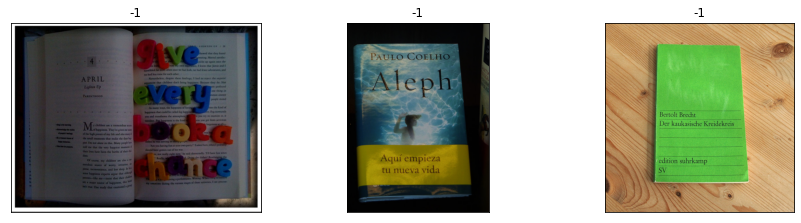

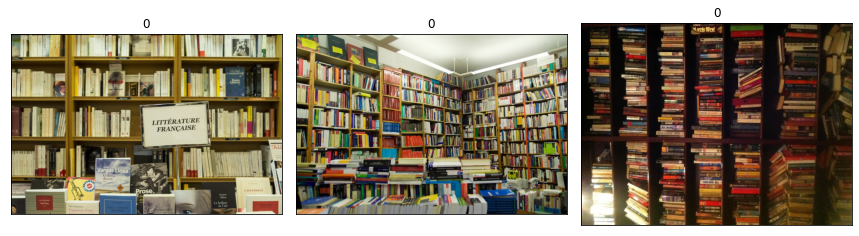

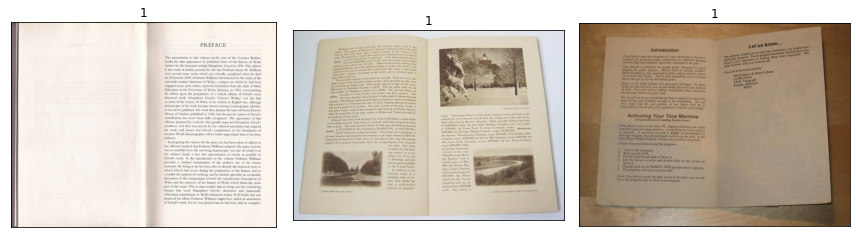

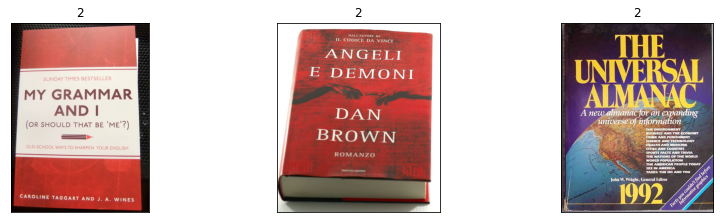

In [13]:
import sys
sys.path.append("../")
import logging
import tempfile
import os
import argparse
from os.path import join
import random
import joblib
import numpy as np
from ml.utils.image import read_images_from_list, show_images
import logging 
import matplotlib.pyplot as plt
import ipyplot

from ml.extractors.vgg16_extractor import VGG16Extractor
from ml.models.DBSCAN import DBSCANv2
from ml.similarity.detector import ImageSimilarityDetector
from ml.utils.image import read_images_from_folder

# Setup extractor, model and similarity detector 
print("Creating image similarity model...")
extractor = VGG16Extractor()
model = DBSCANv2(eps=eps, min_samples=min_samples, metric=metric)
detector = ImageSimilarityDetector(extractor, model)


# List the input folder
print("Reading images from %s...", input_dir)
files = []

for r, _, f in os.walk(input_dir):
    for file in f:
        files.append(join(r, file))
    if not recursive:
        break
# Randomly select fraction of images for training
files = random.sample(files, int(len(files) * fraction))
# Read images
images, _ = read_images_from_list(files)

# Training model
print("Training similarity model...")
labels = detector.train(images)

# Saving model
path = '../custom-skills-deployment/models/'
report_path = '../models'
print("Training completed. Registering model...")
file_name = f'{model_name}.pkl'
tags = {
    "min_samples": min_samples,
    "eps": eps,
    "metric": metric
}
joblib.dump(value=detector.model, filename=os.path.join(path, file_name))

# Saving clustering report
if not os.path.isdir(path):
    os.makedirs(os.path.join(report_path, 'report'))
else:
    cluster_ids = np.unique(labels)
    for cluster_id in cluster_ids:
        sub_images = images[labels == cluster_id]
        cluster = np.random.choice(sub_images, min(report_n_samples, len(sub_images)), replace=False)
        cluster_labels = [cluster_id] * len(cluster)
        fig = show_images(cluster, cols=4, titles=cluster_labels)
        fig.savefig(os.path.join(report_path, 'report', f'cluster_{cluster_id}_samples.png'))

